In [1]:
import scanpy as sc
import numpy as np
import random
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "G:/Shared drives/Opossum transcriptomics/Data/Mouse_M1/Mouse_M1_Raw.h5ad"
adata = sc.read_h5ad(data_path)

In [2]:
adata.obs = adata.obs[["class_label", "cluster_label"]]
sample_IDs = [barcode.split("_")[0] for barcode in adata.obs.index]
adata.obs["batch"] = sample_IDs

adata.X = adata.X.astype(float)

In [4]:
adata_raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:12): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:28)
computing neighbors
    using 'X_pca' with n_pcs = 40


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:56)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


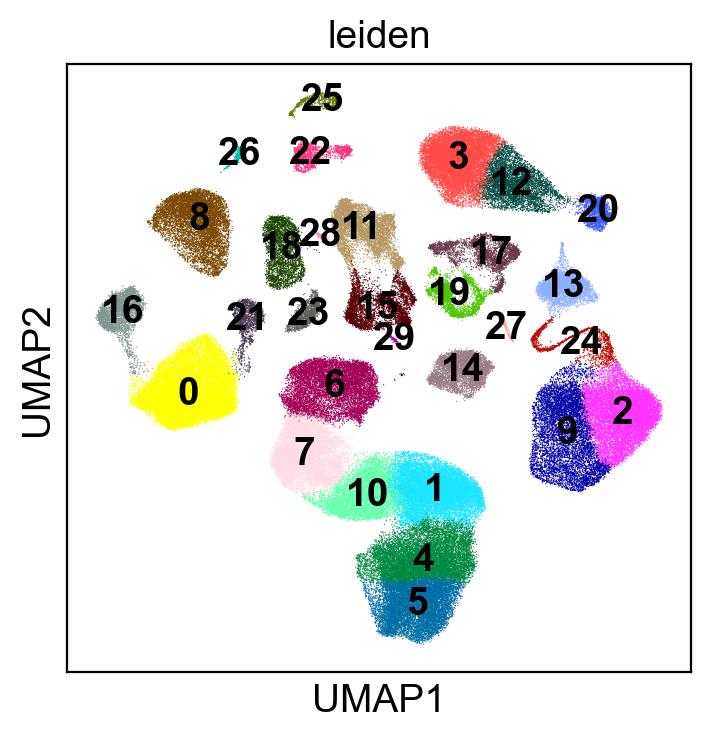

In [5]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


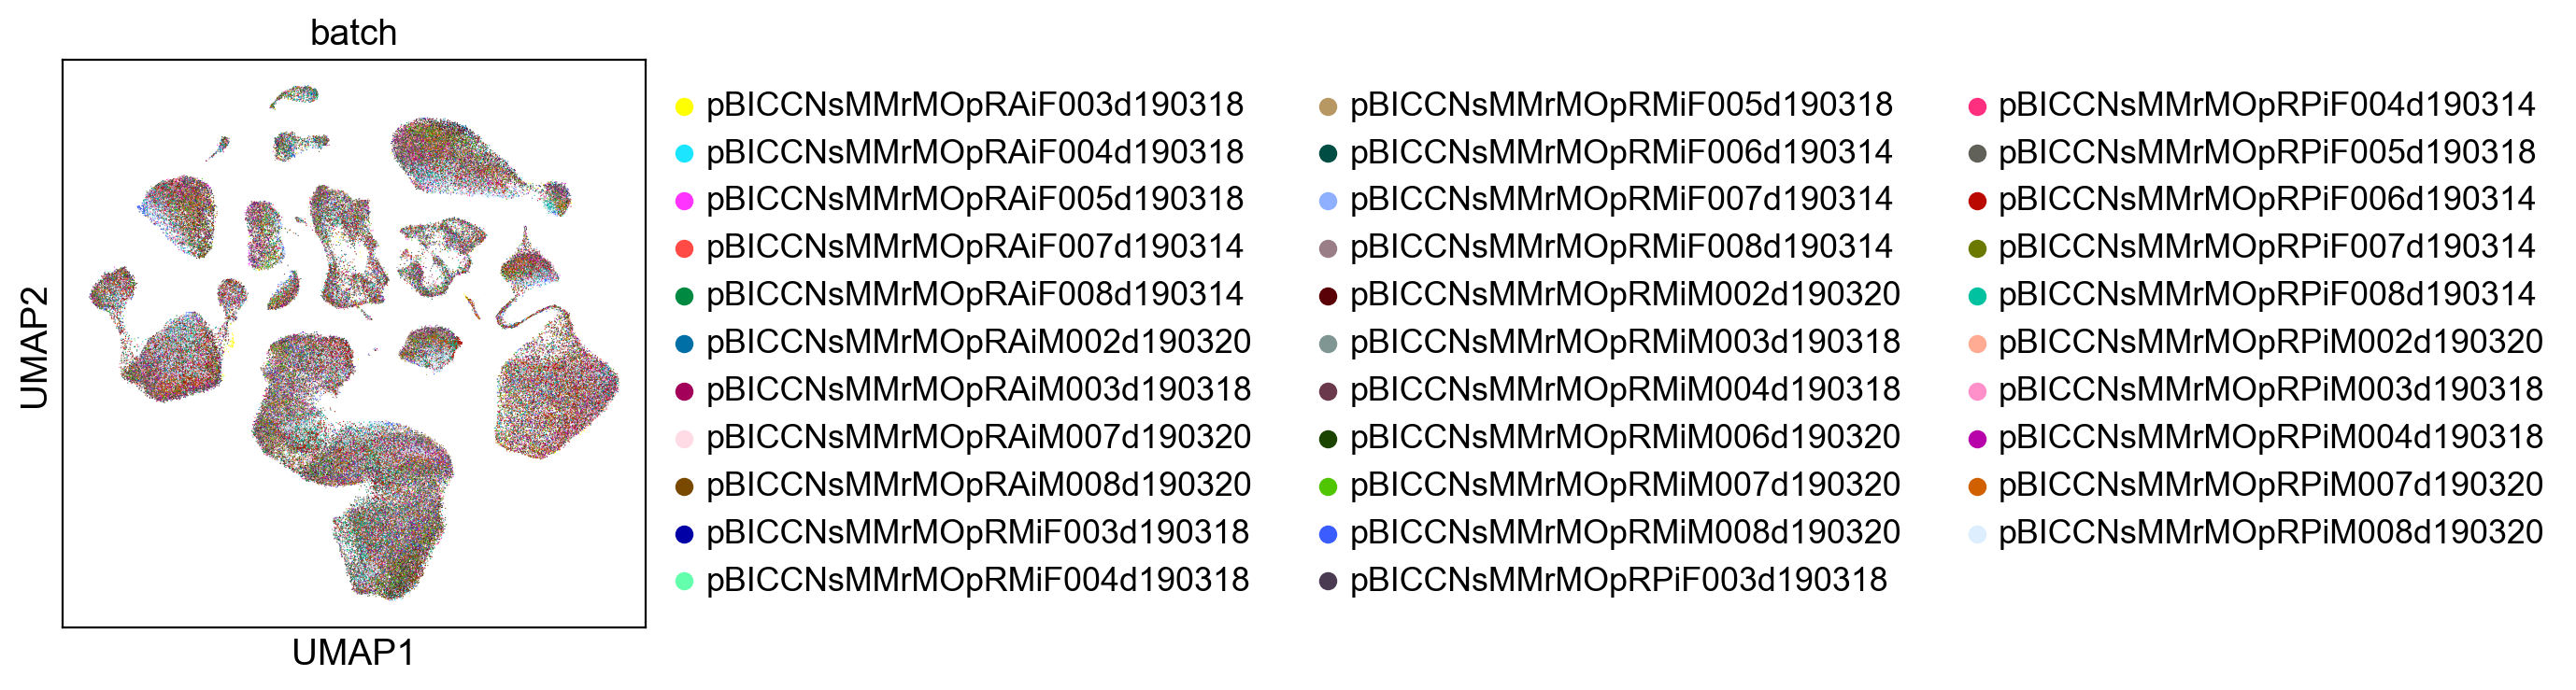

In [6]:
sc.pl.umap(adata, color=["batch"])

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


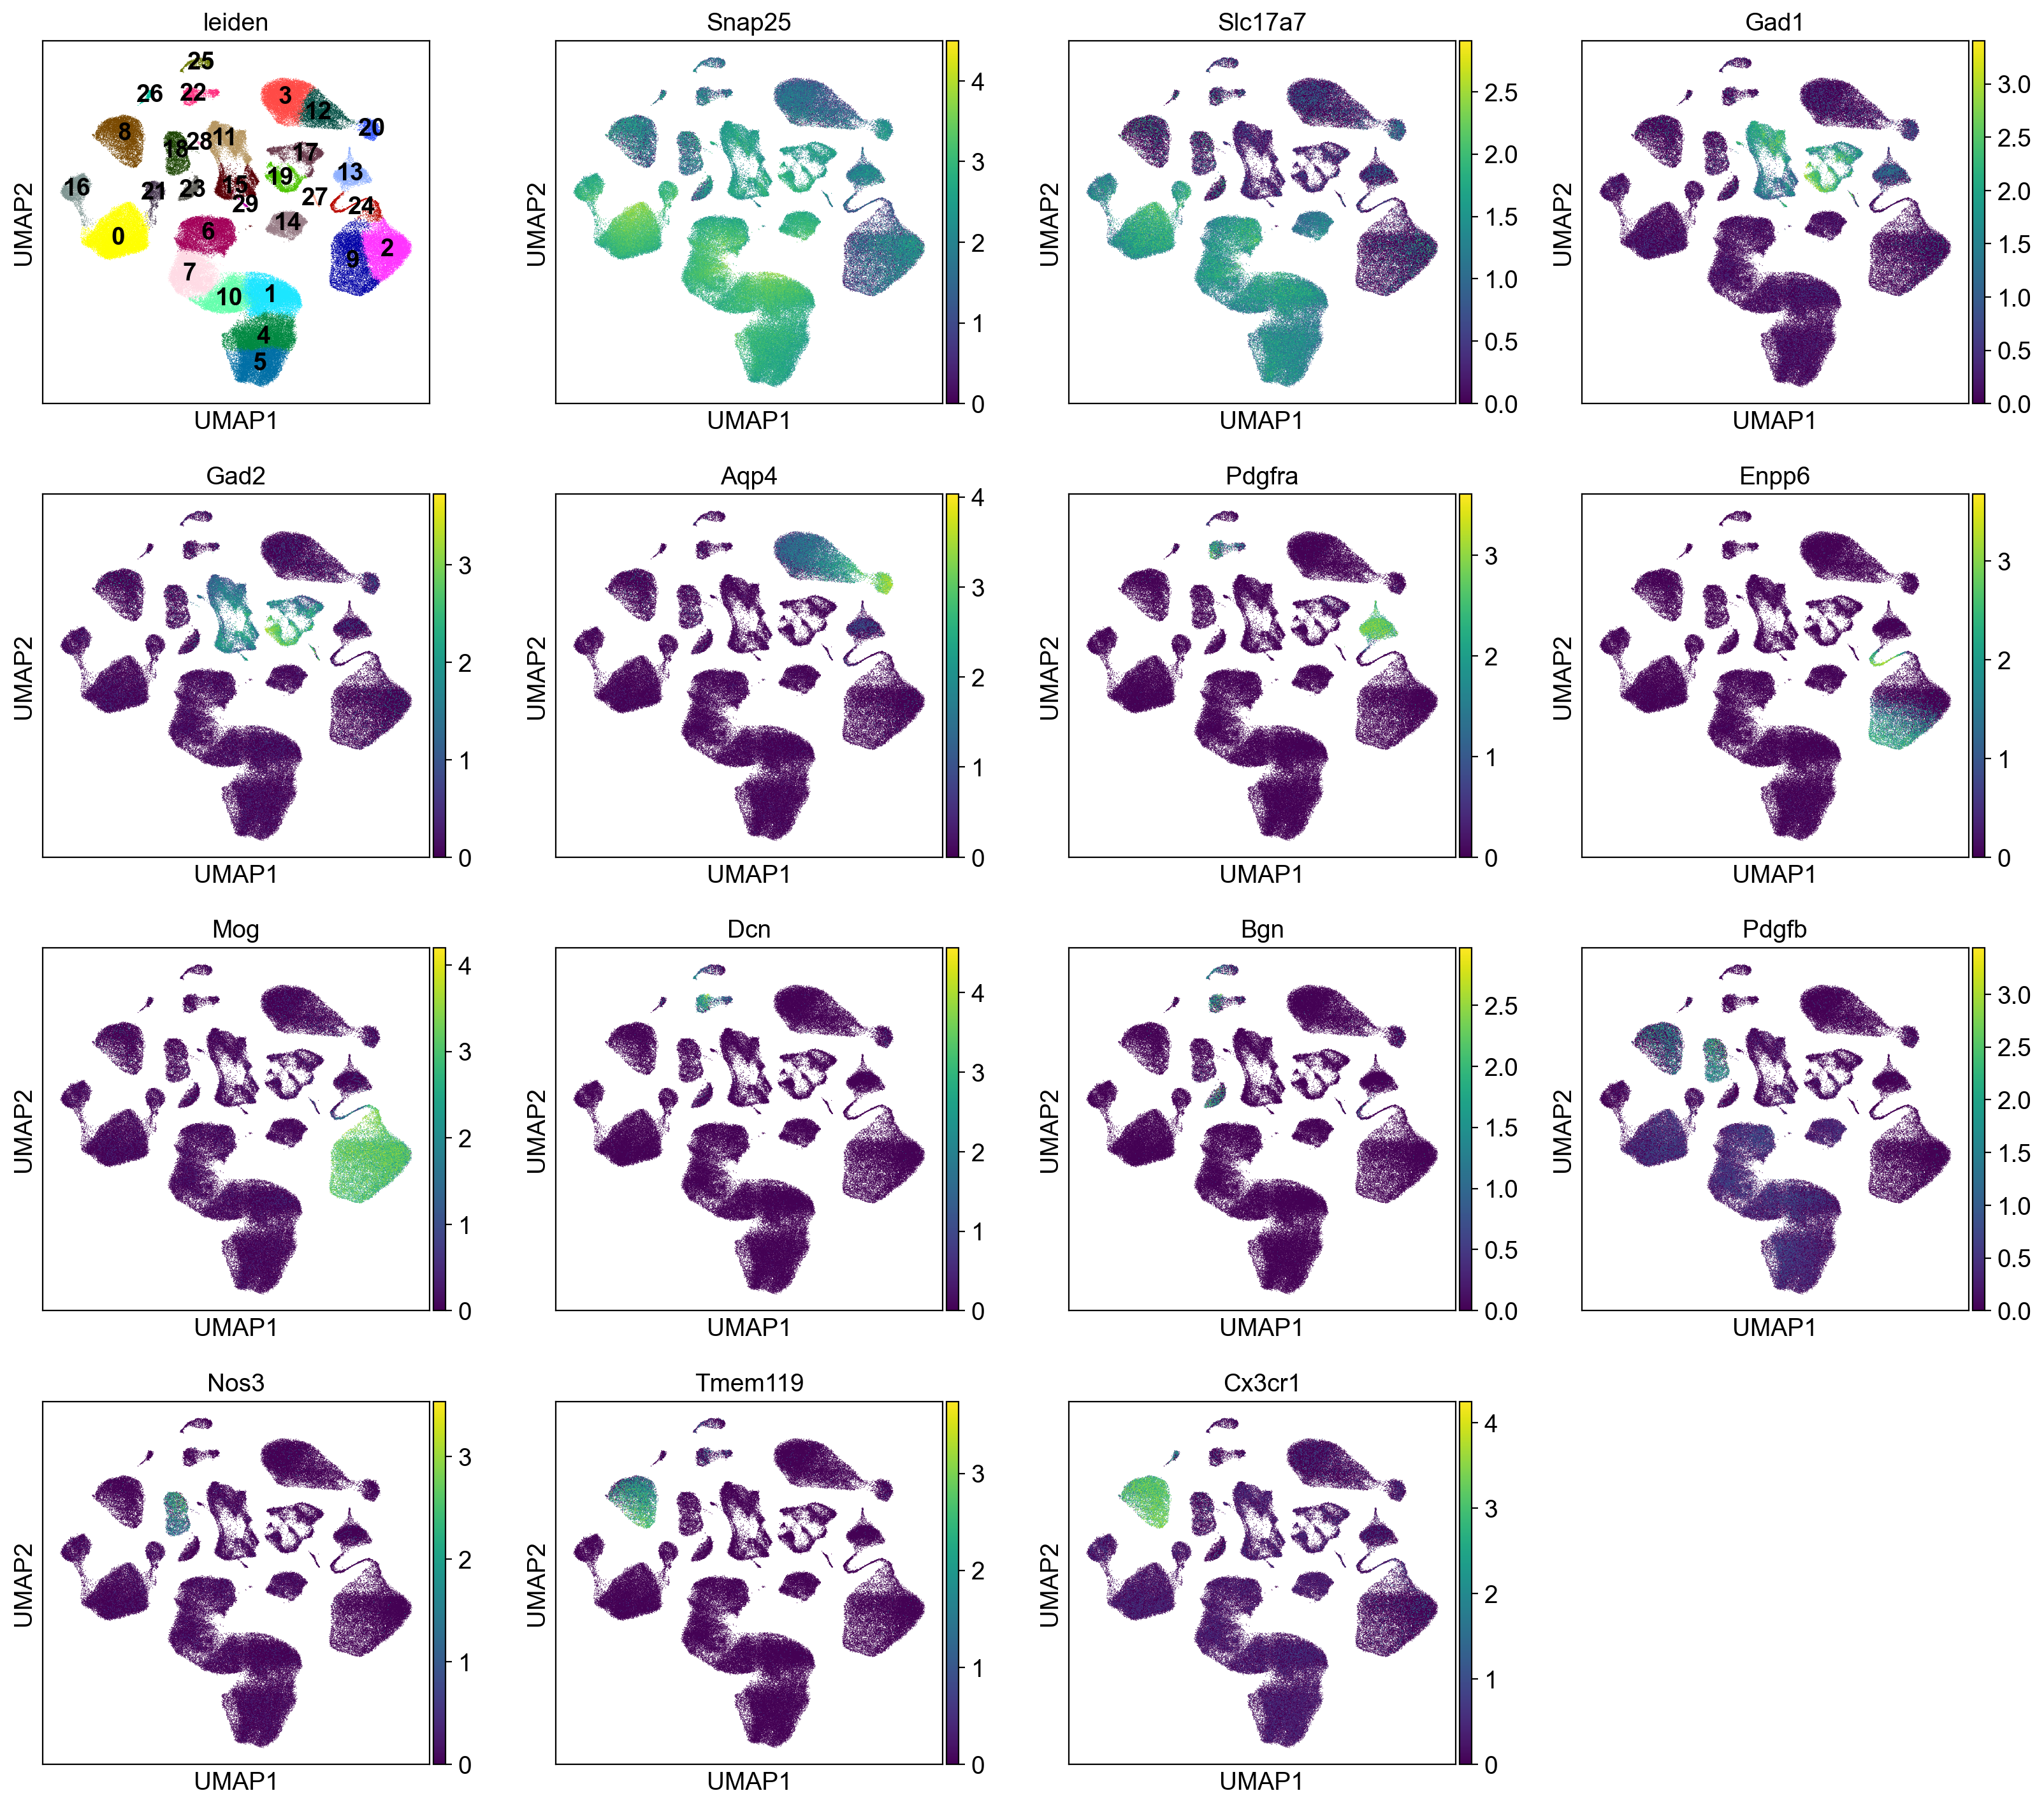

In [7]:
class_markers = [
                 "Snap25", "Slc17a7", # glutamatergic neurons
                 "Gad1", "Gad2", # GABAergic neurons
                 "Aqp4", # astrocytes
                 "Pdgfra", # OPCs
                 "Enpp6", "Mog", # oligodendrocytes
                 "Dcn", "Bgn", # vascular & leptomeningeal cells
                 "Pdgfb", "Nos3", # endothelial cells
                 "Tmem119", "Cx3cr1", # microglia
                ]

sc.pl.umap(adata, color=["leiden"] + class_markers, legend_loc="on data")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Ryan\GitHub\scanpy\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


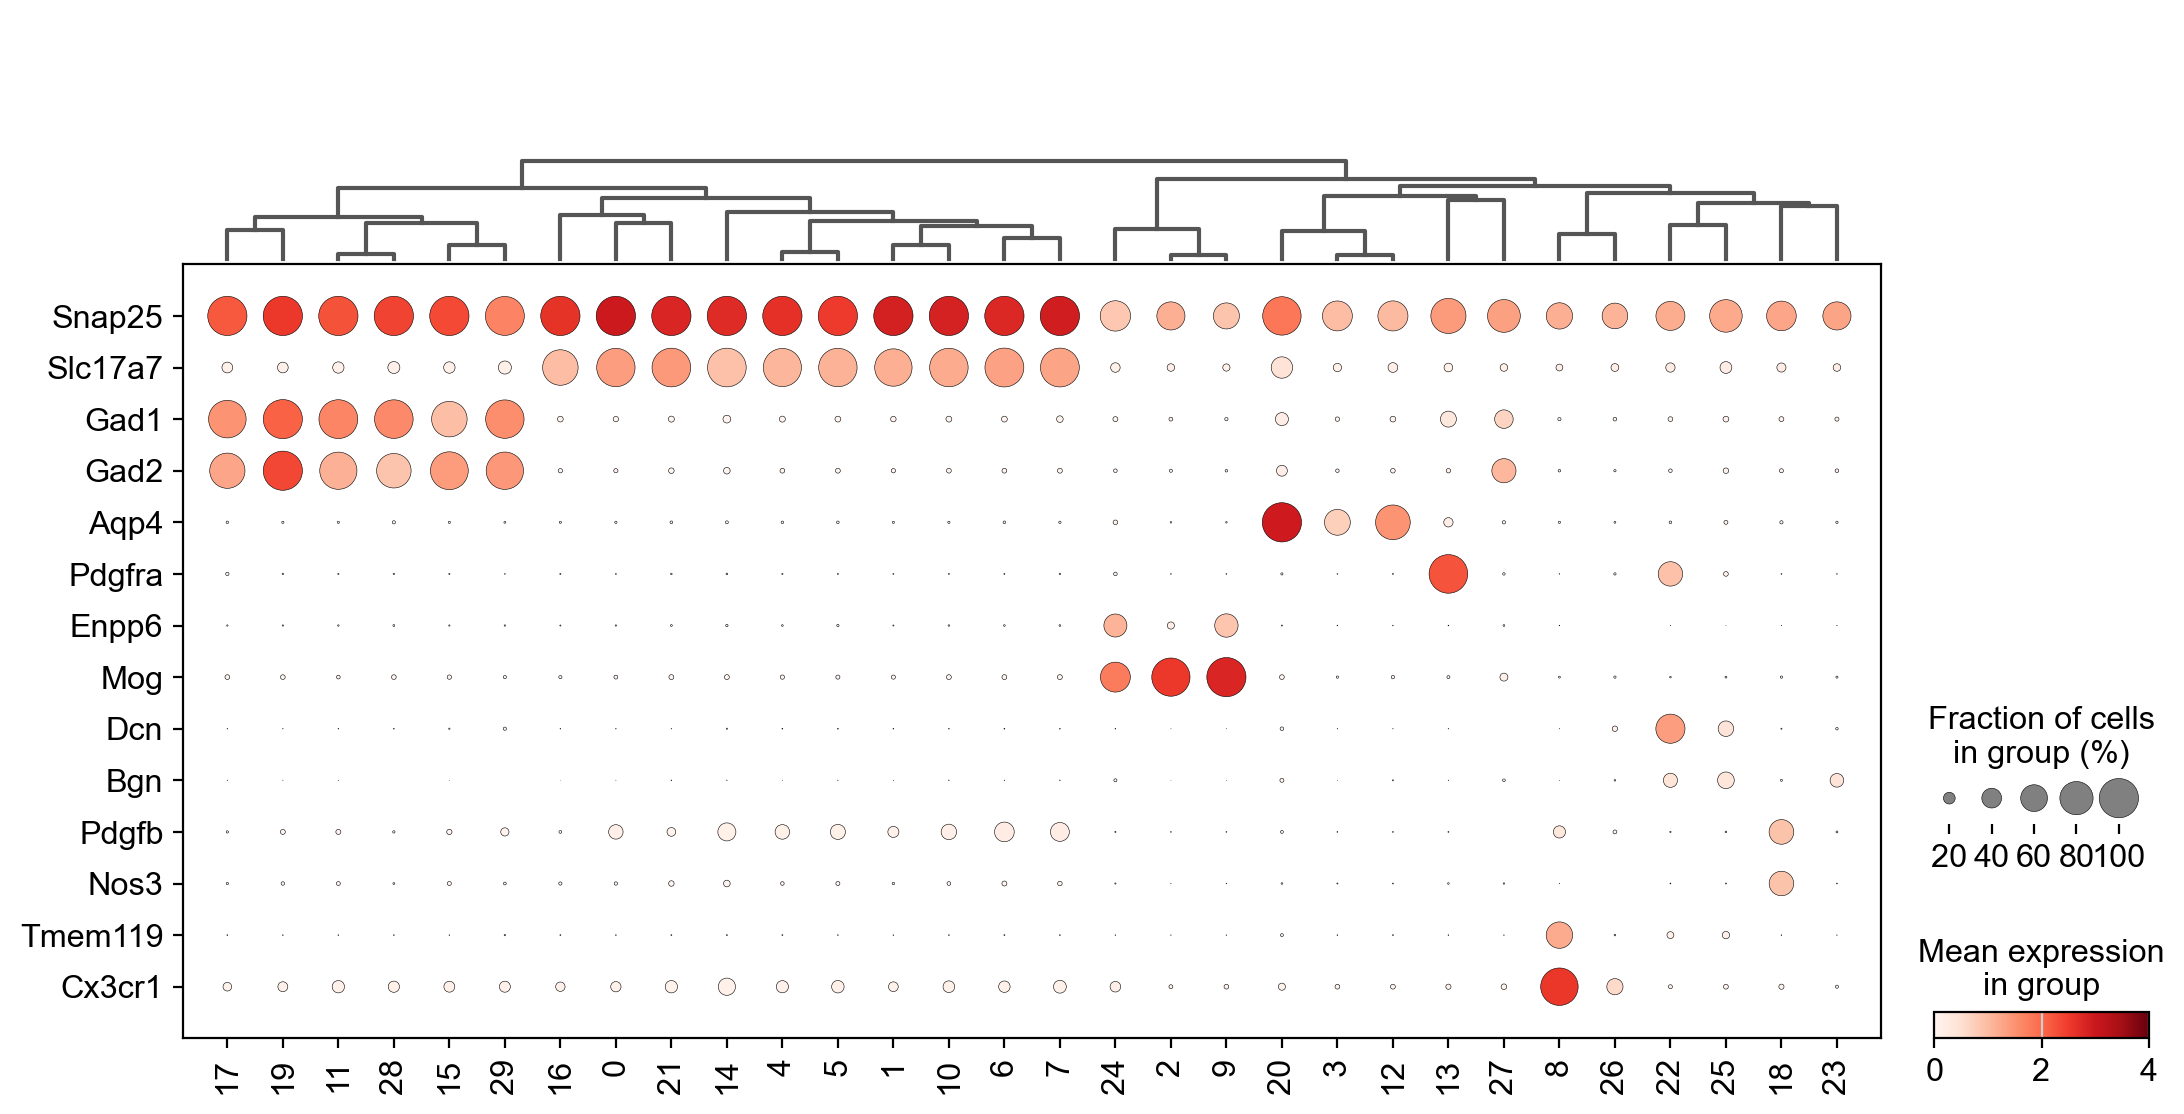

In [8]:
sc.pl.dotplot(adata, class_markers, groupby="leiden", swap_axes=True, dendrogram=True, vmin=0, vmax=4)

In [12]:
class_idx = {
        "glutamatergic" : ["0", "1", "4", "5", "6", "7", "10", "14", "16", "21"], 
        "GABAergic" : ["11", "15", "17", "19", "28", "29", "30"], 
        "non-neuronal" : ["2", "3", "8", "9", "12", "13", "18", "20", "23", "24", "25", "26"], 
        "ambiguous" : ["22", "27"], 
            }

adata.obs["class"] = [None] * adata.shape[0]

for name, idx in class_idx.items():
    mask = np.isin(adata.obs["leiden"], idx)
    adata.obs.loc[mask, "class"] = [name] * np.sum(mask)

In [10]:
adata

AnnData object with n_obs × n_vars = 159738 × 31053
    obs: 'class_label', 'cluster_label', 'batch', 'n_counts', 'leiden', 'class'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'batch_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


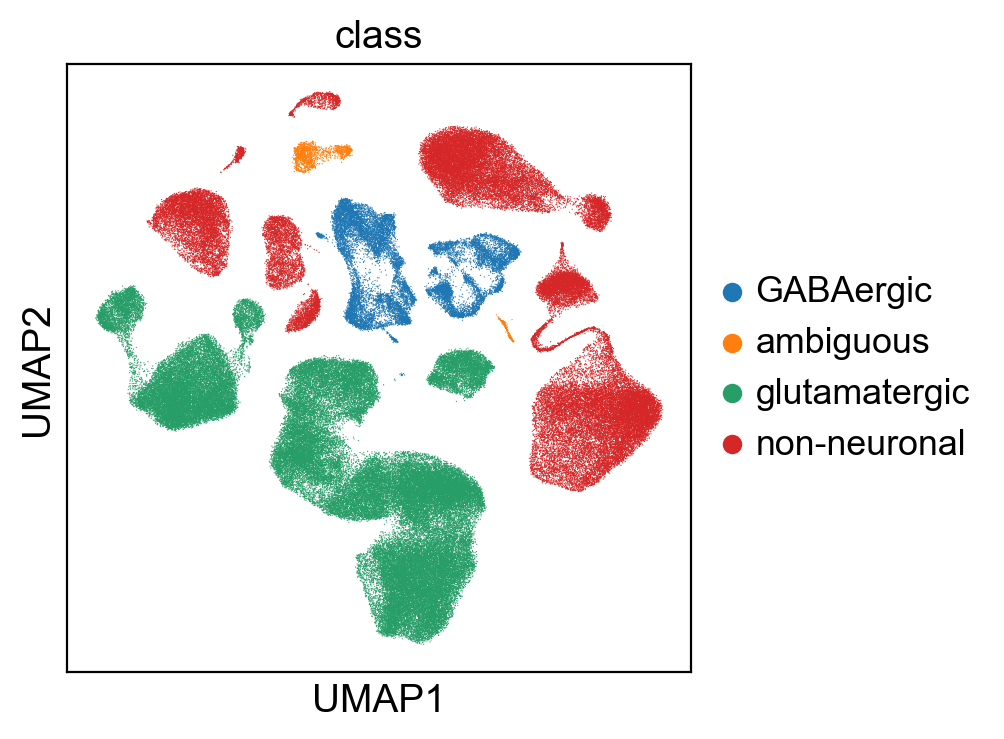

In [13]:
sc.pl.umap(adata, color=["class"])

In [15]:
save_path = "G:/Shared drives/Opossum transcriptomics/Data/Mouse_M1/"

adata_raw.obs = adata.obs
adata_raw.write_h5ad(save_path + "Mouse_M1_All.h5ad")

adata.write_h5ad(save_path + "Mouse_M1_All_Clustered.h5ad")

for classname, filename in zip(["glutamatergic", "GABAergic", "non-neuronal"], ["Glut", "GABA", "Non"]):
    adata_class = adata[adata.obs["class"] == classname, :]
    del adata_class.uns
    del adata_class.obsm
    del adata_class.varm
    del adata_class.obsp

    adata_class.write_h5ad(save_path + "Mouse_M1_" + filename + ".h5ad")